In [44]:
import numpy as np
import timing
import matplotlib.pyplot as plt
import matplotlib.colors as cm
import pynbody
from michaels_functions import center_and_r_vir, remove_bulk_velocity
from matplotlib.colors import LogNorm
from matplotlib.pyplot import figure

In [45]:
path = "bulk1/data_2/hydro_59/output/"
data = pynbody.load(path + "output_00050")
aexp = data.properties['a']
data.physical_units()
r_vir = center_and_r_vir(data, aexp, path)
remove_bulk_velocity(data)
r_e = 0.1 * r_vir
sph_5 = pynbody.filt.Sphere(radius = '5.0 kpc') # %(r_e*1.4))
region = data[sph_5]
rho = region.gas["rho"].in_units("m_p cm**-3")
f = open(data.filename + "/info_"+data.filename[-5:]+".txt","r")
lines = f.readlines()
f.close()
for line in lines:
    if line[0:13]=="unit_l      =":
        print line[:-1]
        unit_l = float(line[14:-1])
    if line[0:13]=="unit_d      =":
        print line[:-1]
        unit_d = float(line[14:-1])
    if line[0:13]=="unit_t      =":
        print line[:-1]
        unit_t = float(line[14:-1])
    if line[0:13]=="omega_b     =":
        print line[:-1]
        omega_b = float(line[14:-1])

('shifting on Stars:', SimArray([ 0.00308878, -0.03302971, -0.04676732], 'kpc'))
('virial radius:', SimArray(152.40432611, 'kpc'))
omega_b     =  0.450000017881393E-01
unit_l      =  0.682025380323961E+26
unit_d      =  0.123367583719985E-28
unit_t      =  0.163687521954501E+18


In [79]:
def make_pdf(s, s_bar, sigma_s):
    pdf = (1./np.sqrt(2*np.pi*(sigma_s**2))) * (np.exp(-0.5*(((s - s_bar)/sigma_s)**2)))
    return pdf

def calc_lambda_jeans(n_H, c_s, m_p):
    lambda_jeans = (c_s / np.sqrt(4* np.pi * G * n_H * m_p))
    return lambda_jeans

def calc_n_LW(n_H, G_o, lambda_jeans, Z, m_p):
    kappa = 1000 * m_p * Z
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    n_LW = rad_field_outside * exp_tau
    return n_LW

def calc_X_H2(n_H, Z, n_LW):
    DC = 1.7e-11
    CC = 2.5e-17            #cm3 s-1
    numerator = DC * n_LW
    denominator = CC * Z * n_H
    X_H2 = 1. / (2 + (numerator/denominator) )
    return X_H2

def calc_n_LW_ss(n_H, n_H2, G_o, lambda_jeans, m_p):
    kappa = 1000 * m_p * Z
    rad_field_outside = G_o #in solar units
    exp_tau = np.exp(-kappa * n_H * lambda_jeans)
    N_H2 = n_H2 * lambda_jeans
    term1 = pynbody.array.SimArray((0.965/((1+(N_H2/5e14))**2)), "1")
    term2 = ( (0.035/np.sqrt(1+(N_H2/5e14))) * np.exp(-1*np.sqrt(1+(N_H2/5e14))/1180) )
    S_H2 = term1 + term2
    n_LW_ss = rad_field_outside * exp_tau * S_H2
    return n_LW_ss

def self_shielding_iterations(n_H, G_o, lambda_jeans, Z, m_p):
    n_LW = np.zeros(100)
    X_H2 = np.zeros(100)
    n_H2 = np.zeros(100)
    n_LW_ss = np.zeros(100)
    S_H2_ss = np.zeros(100)
    N_H2_ss = np.zeros(100)
    X_H2_ss = np.zeros(100)
    n_H2_ss = np.zeros(100)
    ctr = 16
    i = 0
    n_LW = calc_n_LW(n_H, G_o, lambda_jeans, Z, m_p)
    X_H2 = calc_X_H2(n_H, Z, n_LW)
    n_H2 = n_H * X_H2
    n_H2_ss = n_H2
    while i<ctr:
        n_LW_ss = calc_n_LW_ss(n_H, n_H2_ss, G_o, lambda_jeans, m_p)
        X_H2_ss = calc_X_H2(n_H, Z, n_LW_ss)
        n_H2_ss = n_H * X_H2_ss
        i += 1
    return n_LW, n_H2, n_LW_ss, X_H2_ss, n_H2_ss

# def calc_integral1(s, pdf, X_H2_ss, ds):
#     integ1 = 0.0
#     for i in range(0, 100):
#         integ1 += np.exp(s[i]) * pdf[i] * X_H2_ss[i] * ds
#     return integ1

def calc_X_CO(n_H, n_H2, n_LW):
    rate_CHX = 5.0e-10 * n_LW
    rate_CO = 1.0e-10 * n_LW
    x0 = 2.0e-4
    k0 = 5.0e-16 #cm3 s-1
    k1 = 5.0e-10 #cm3 s-1
    factor_beta = rate_CHX/(n_H*k1*x0)
    beta = 1./(1.+factor_beta)
    factor_CO = rate_CO/(n_H2*k0*beta)
    X_CO = 1./(1.+factor_CO)
    return X_CO

def calc_n_CO(n_H, X_CO, Z):
    abundance_Ctot = 1e-4 # n_C/n_H as defined by nucleosynthesis
    return n_H * abundance_Ctot * Z * X_CO # CO/cc

# def calc_integral2(s, pdf, X_CO, ds):
#     integ2 = 0.0
#     for i in range(0, 100):
#         integ2 += np.exp(s[i]) * pdf[i] * X_CO[i] * ds
#     return integ2

# def inside_loop(mach_no, n_H_mean, Z, G_o, c_s, m_p):
#     s = np.zeros(100)
#     n_H = np.zeros(100)
#     pdf = np.zeros(100)
#     lambda_jeans = np.zeros(100)
#     X_CO = np.zeros(100)
#     n_CO = np.zeros(100)
#     integral1 = 0.0
#     integral2 = 0.0
#     sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
#     s_bar = -0.5*(sigma_s**2)
#     smin = -7*sigma_s + s_bar
#     smax = 7*sigma_s + s_bar
#     ds = (smax - smin)/100

#     for i in range(0, 100):
#         s[i] = smin + i*ds

#     n_H = n_H_mean * np.exp(s)
#     pdf = make_pdf(s, s_bar, sigma_s)
#     lambda_jeans = calc_lambda_jeans(n_H, c_s, m_p)
#     n_LW, n_H2, n_LW_ss, X_H2_ss, n_H2_ss = self_shielding_iterations(n_H,
#                                                     G_o, lambda_jeans, Z, m_p)

# #     integral1 = calc_integral1(s, pdf, X_H2_ss, ds)
# #     X_H2_bar = 2 * integral1

#     X_CO = calc_X_CO(n_H, n_H2, n_LW)
#     n_CO = calc_n_CO(n_H, X_CO, Z)

# #     integral2 = calc_integral2(s, pdf, X_CO, ds)
# #     X_CO_bar = integral2

#     return s, n_H, pdf, lambda_jeans, n_LW, n_H2, n_LW_ss, X_H2_ss, n_H2_ss, X_CO, n_CO

In [103]:
m_p = pynbody.array.SimArray(1.672621777e-24, "g")
K_b = pynbody.array.SimArray(1.38064852e-16, "cm**2 g s**-2 K**-1")
G = pynbody.array.SimArray(6.67259e-8, "cm**3 g**-1 s**-2")
T_mean = pynbody.array.SimArray(10., "K")

turb = np.sqrt( region.g["turb"] * 2./3. ) * unit_l / unit_t / 1e5
turb = pynbody.array.SimArray(turb*1e5, units = "cm s**-1")

temperature = region.g["temp"]
c_s_arr = np.sqrt(K_b * temperature / m_p)

mach_no_sim = turb / c_s_arr
region.g["mach"] = mach_no_sim.in_units("1")

m_p_1 = pynbody.array.SimArray(1.0, pynbody.units.m_p)
n_H_mean_sim = rho / m_p_1

Z_arr = pynbody.array.SimArray(np.logspace(-4, -1, 10), '1')/0.02
G_o = 1

mach_no_arr = pynbody.array.SimArray(np.logspace(-2, 3, 10), '1')
n_H_mean_arr = pynbody.array.SimArray(np.logspace(-5, 4, 10), "cm**-3")

s = np.zeros((len(mach_no_arr), 100))
n_H = np.zeros((len(mach_no_arr), 100))
pdf = np.zeros((len(mach_no_arr), 100))
lambda_jeans = np.zeros((len(mach_no_arr), 100))
n_LW = np.zeros((len(mach_no_arr), 100))
n_H2 = np.zeros((len(mach_no_arr), 100))
n_LW_ss = np.zeros((len(mach_no_arr), 100))
X_H2_ss = np.zeros((len(mach_no_arr), 100))
n_H2_ss = np.zeros((len(mach_no_arr), 100))
X_CO = np.zeros((len(mach_no_arr), 100))
n_CO = np.zeros((len(mach_no_arr), 100))

In [97]:
for m in range(0, len(mach_no_arr)):
    mach_no = mach_no_arr[m]
    n_H_mean = n_H_mean_arr[m]
    Z = Z_arr[m]
    c_s = c_s_arr[m]    
    sigma_s = np.sqrt(np.log(1 + ((0.3 * mach_no)**2)))
    s_bar = -0.5*(sigma_s**2)
    smin = -4*sigma_s + s_bar
    smax = 4*sigma_s + s_bar
    ds = (smax - smin)/100
    for i in range(0, 100):
        s[m][i] = smin + i*ds
    n_H = n_H_mean * np.exp(s)
    pdf = make_pdf(s, s_bar, sigma_s)
    lambda_jeans = calc_lambda_jeans(n_H, c_s, m_p)
    n_LW, n_H2, n_LW_ss, X_H2_ss, n_H2_ss = self_shielding_iterations(n_H,
                                                    G_o, lambda_jeans, Z, m_p)
    X_CO = calc_X_CO(n_H, n_H2, n_LW)
    n_CO = calc_n_CO(n_H, X_CO, Z)

In [98]:
np.shape(n_H)

(10, 100)

In [99]:
min_M = np.min(mach_no_arr)
max_M = np.max(mach_no_arr)
min_Z = np.min(Z_arr)
max_Z = np.max(Z_arr)

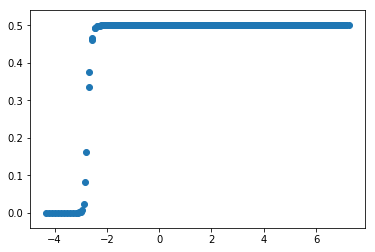

In [101]:
plt.scatter(np.log10(n_H[:][:]), X_H2_ss[:][:])

In [85]:
X_H2_ss[3][:]

SimArray([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
          0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
          0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
          0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
          0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
          0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
          0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
          0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], 'cm**3/2 g**-1 s**-1')

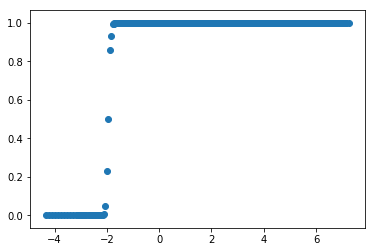

In [102]:
plt.scatter(np.log10(n_H), X_CO)

In [124]:
count = 0
for abc in range(0, len(temperature)):
    n = np.log10(n_H_mean_sim[abc])
    T = temperature[abc]
    if (T>=1e4) | (n<=-2):
        count+=1
print count

193003


In [125]:
len(temperature)

244522

In [126]:
len(temperature) - count

51519